In [1]:
import torch
import math
import copy
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.modules import ModuleList
from torch.nn.modules.normalization import LayerNorm
import torch.nn as nn
import pytorch_checkmate
from importlib import reload

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [2]:
class Conv1D(nn.Module):
    def __init__(self, nx, nf):
        super().__init__()
        self.nf = nf
        w = torch.empty(nx, nf)
        nn.init.normal_(w, std=0.02)
        self.weight = nn.Parameter(w)
        self.bias = nn.Parameter(torch.zeros(nf))

    def forward(self, x):
        size_out = x.size()[:-1] + (self.nf,)
        x = torch.addmm(self.bias, x.view(-1, x.size(-1)), self.weight)
        x = x.view(size_out)
        return x
    
    
class FeedForward(nn.Module):
    def __init__(self, dropout, d_model=768, nx=768*4):
        super().__init__()
        self.c_fc    = Conv1D(d_model, nx)
        self.c_proj  = Conv1D(nx, d_model)
        self.act     = F.gelu
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        return self.dropout(self.c_proj(self.act(self.c_fc(x))))
    
    
class Attention(nn.Module):
    def __init__(self, d_model=768, n_head=12, n_ctx=1024, d_head=64, bias=True, scale=False, dropout=0.1):
        super().__init__()
        self.n_head  = n_head
        self.d_model = d_model
        self.c_attn  = Conv1D(d_model, d_model*3)
        self.scale   = scale
        self.softmax = nn.Softmax(dim=-1)
        self.register_buffer("bias", torch.tril(torch.ones(n_ctx, n_ctx)).view(1, 1, n_ctx, n_ctx))
        self.dropout = nn.Dropout(dropout)
        self.c_proj  = Conv1D(d_model, d_model)
        
    def split_heads(self, x):
        "return shape [`batch`, `head`, `sequence`, `features`]"
        new_shape = x.size()[:-1] + (self.n_head, x.size(-1)//self.n_head) 
        x = x.view(new_shape)
        return x.permute(0, 2, 1, 3) 
    
    def _attn(self, q, k, v, attn_mask=None):
        scores  = torch.matmul(q, k.transpose(-2, -1))
        if self.scale: scores = scores/math.sqrt(v.size(-1))
        nd, ns  = scores.size(-2), scores.size(-1)
        if attn_mask is not None: scores = scores + attn_mask
        scores  = self.softmax(scores)
        scores  = self.dropout(scores)
        outputs = torch.matmul(scores, v)
        return outputs
    
    def merge_heads(self, x):
        x         = x.permute(0, 2, 1, 3).contiguous()
        new_shape = x.size()[:-2] + (x.size(-2)*x.size(-1),)
        return x.view(new_shape)
        
    def forward(self, x):
        x        = self.c_attn(x) #new `x` shape - `[1,3,2304]`
        q, k, v  = x.split(self.d_model, dim=2)
        q, k, v  = self.split_heads(q), self.split_heads(k), self.split_heads(v)
        # out      = self._attn(q, k, v)
        scores  = torch.matmul(q, k.transpose(-2, -1))
        # if self.scale: scores = scores/math.sqrt(v.size(-1))
        nd, ns  = scores.size(-2), scores.size(-1)
        # if attn_mask is not None: scores = scores + attn_mask
        scores  = self.softmax(scores)
        scores  = self.dropout(scores)
        out = torch.matmul(scores, v)
        
        out      = self.merge_heads(out)
        out      = self.c_proj(out)
        return out
    
class TransformerBlock(nn.Module):
    def __init__(self, d_model=768, n_head=12, dropout=0.1):
        super(TransformerBlock, self).__init__()
        self.attn        = Attention(d_model=d_model, n_head=n_head, d_head=64, n_ctx=1024, bias=True, scale=False, dropout=dropout)
        self.feedforward = FeedForward(dropout=dropout, d_model=d_model, nx=d_model*4)
        self.ln_1        = LayerNorm(d_model)
        self.ln_2        = LayerNorm(d_model)
                
    def forward(self, x):
        x1 = self.ln_1(x)
        x2 = self.ln_2(x)
        x = x + self.attn(x1)
        x = x + self.feedforward(x2)
        return x
    
def _get_clones(module, n):
    return ModuleList([copy.deepcopy(module) for i in range(n)])

class GPT2(nn.Module):
    def __init__(self, nlayers=12, n_ctx=1024, d_model=768, vcb_sz=50257, dropout=0.1):
        super(GPT2, self).__init__()
        self.nlayers = nlayers
        block        = TransformerBlock(d_model=d_model, n_head=12, dropout=dropout)
        self.h       = _get_clones(block, nlayers)
        self.wte     = nn.Embedding(vcb_sz, d_model)
        self.wpe     = nn.Embedding(n_ctx, d_model)
        self.drop    = nn.Dropout(dropout)
        self.ln_f    = LayerNorm(d_model)
        self.out     = nn.Linear(d_model, vcb_sz, bias=False)
        self.loss_fn = nn.CrossEntropyLoss()
        self.init_weights()
    
    def init_weights(self):
        self.out.weight = self.wte.weight
        self.apply(self._init_weights)
    
    def _init_weights(self, module):
        if isinstance(module, (nn.Linear, nn.Embedding, Conv1D)):
            module.weight.data.normal_(mean=0.0, std=0.02)
            if isinstance(module, (nn.Linear, Conv1D)) and module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)
    
    def forward(self, src, labels=None, pos_ids=None, return_inp=False, dropout=0.1):
        if pos_ids is None: pos_ids = torch.arange(0, src.size(-1), device=device).unsqueeze(0)
        inp = self.drop((self.wte(src)+self.wpe(pos_ids)))
        if return_inp: return inp 
        for i in range(self.nlayers): inp = self.h[0](inp)
        inp     = self.ln_f(inp)
        logits  = self.out(inp)
        outputs = (logits,) + (inp,)
        
        if labels is not None:
            shift_logits = logits[..., :-1, :].contiguous()
            shift_labels = labels[..., 1:].contiguous()
            loss = self.loss_fn(shift_logits.view(-1, shift_logits.size(-1)), shift_labels.view(-1))
            outputs = (loss,) + outputs
            return outputs
        return logits

In [3]:
from transformers import GPT2Tokenizer
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
context1  = torch.tensor([tokenizer.encode("The planet earth")], device=device)
context2  = torch.tensor([tokenizer.encode("I'm upset with those tools")], device=device)
print(context1)

tensor([[ 464, 5440, 4534]], device='cuda:0')


In [4]:
model2 = GPT2(nlayers=1,dropout=0, d_model=768//2)
model2.to(device)

GPT2(
  (h): ModuleList(
    (0): TransformerBlock(
      (attn): Attention(
        (c_attn): Conv1D()
        (softmax): Softmax(dim=-1)
        (dropout): Dropout(p=0, inplace=False)
        (c_proj): Conv1D()
      )
      (feedforward): FeedForward(
        (c_fc): Conv1D()
        (c_proj): Conv1D()
        (dropout): Dropout(p=0, inplace=False)
      )
      (ln_1): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
      (ln_2): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
    )
  )
  (wte): Embedding(50257, 384)
  (wpe): Embedding(1024, 384)
  (drop): Dropout(p=0, inplace=False)
  (ln_f): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
  (out): Linear(in_features=384, out_features=50257, bias=False)
  (loss_fn): CrossEntropyLoss()
)

In [5]:
GPT2_Bg = pytorch_checkmate.read_trace_code.make_B_graph(model2,(context1,))

/tmp/ipykernel_25956/1697464919.py:43: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  new_shape = x.size()[:-1] + (self.n_head, x.size(-1)//self.n_head)


In [6]:
#pytorch_checkmate.Dtools.print_all_fw_nodes(GPT2_Bg,print_ast=False)

In [7]:
GPT2_Dg = pytorch_checkmate.Dtools.B_to_D(GPT2_Bg,model2,{"src":context1})

In [8]:
GPT2_Sg = pytorch_checkmate.Stools.D_to_S(GPT2_Dg)

In [9]:
GPT2_Kg = pytorch_checkmate.Ktools.S_to_K(GPT2_Sg,model2,{"src":context1})

/home/shawn/anaconda3/lib/python3.9/site-packages/torch/cuda/memory.py:271: FutureWarning: torch.cuda.reset_max_memory_allocated now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  warnings.warn(


In [10]:
pytorch_checkmate.Ktools.print_K_graph(GPT2_Kg)

38


In [11]:
budget = 700000
reload(pytorch_checkmate)
sched_result, g = pytorch_checkmate.use_chk.make_sched(GPT2_Kg, budget, use_gurobi=True, verbose=True)

total cost: 827392 max cost: 603136 budget: 700000
Set parameter Username
Academic license - for non-commercial use only - expires 2023-03-23
feasible schedule solved


In [12]:
import numpy as np

print('max_mem in the solution:', np.max(sched_result.ilp_aux_data.U))

max_mem in the solution: 696832


In [13]:
translator = pytorch_checkmate.use_chk.Sched_to_Code(g, GPT2_Kg)

sched_code = translator.generate_sched_code(sched_result)

In [14]:
## To valid the result is correct

torch.random.manual_seed(0)
mymod = GPT2(nlayers=1,dropout=0, d_model=768//2).to('cuda')
context1  = torch.tensor([tokenizer.encode("The planet earth")]).to('cuda')

loss = torch.ones_like(mymod(context1),device=device)
tmp_local = {'self':mymod, 'src':context1, '_loss':loss}


#### Bugs in the code
# indices is int type, and should not require gradient
sched_code[1] = "___11__2 = torch.arange(0, __10__1, 1, dtype=torch.int32, device=torch.device('cuda'), pin_memory=False) ; __11__2 = ___11__2.detach()\n__13_input = torch.unsqueeze(__11__2, 0)"

# replace tensor to torch.tensor
sched_code[11] = sched_code[11].replace('tensor', 'torch.tensor')
####


torch.cuda.reset_peak_memory_stats()
max_before = torch.cuda.max_memory_allocated()

exec(GPT2_Sg.init_node.get_code(), globals(), tmp_local)
for i,code in enumerate(sched_code[:]):
    #print(i,)
    exec(code, globals(), tmp_local)
    
print("=======EXEC SCHED CODE=======")
print("weight grad:", torch.mean(tmp_local['self'].ln_f.weight.grad))
print("peak memory:", torch.cuda.max_memory_allocated()-max_before)

=======EXEC SCHED CODE=======
weight grad: tensor(0.5005, device='cuda:0')
peak memory: 161705984


In [19]:
torch.random.manual_seed(0)
model3 = GPT2(nlayers=1,dropout=0, d_model=768//2).to('cuda')
context1  = torch.tensor([tokenizer.encode("The planet earth")]).to('cuda')

loss = torch.ones_like(model3(context1),device=device)


torch.cuda.reset_peak_memory_stats()
max_before = torch.cuda.max_memory_allocated()

y = model3(context1)
y.backward(loss)


print("=======ORIGINAL MODULE=======")
print("weight grad:", torch.mean(model3.ln_f.weight.grad))
print("peak memory:", torch.cuda.max_memory_allocated()-max_before)


=======ORIGINAL MODULE=======
weight grad: tensor(0.5005, device='cuda:0')
peak memory: 68920832


In [ ]:
### Notice that model is very big in this case

## To understand the memory cost

In [16]:
from checkmate.core.schedule import OperatorEvaluation, DeallocateRegister, AllocateRegister
mem_timeline = []
for i,op in enumerate(sched_result.schedule):
    if isinstance(op, AllocateRegister):
        continue
    else:
        mem_timeline.append(sched_result.schedule_aux_data.mem_timeline[i])
        # mem_timeline.append(sb.ram_timeline[i])

torch.cuda.reset_peak_memory_stats()

mem_timeline_real = []
torch.random.manual_seed(0)
mymod = GPT2(nlayers=1,dropout=0, d_model=768//2).to('cuda')
context1  = torch.tensor([tokenizer.encode("The planet earth")]).to('cuda')

loss = torch.ones_like(mymod(context1),device=device)
tmp_local = {'self':mymod, 'src':context1, '_loss':loss}

torch.cuda.reset_peak_memory_stats()
max_before = torch.cuda.max_memory_allocated()
allo_before = torch.cuda.memory_allocated()
# checkmate schedule is translated into a list of code
exec(GPT2_Sg.init_node.get_code(), globals(), tmp_local)

for i, code in enumerate(sched_code):
    exec(code, globals(), tmp_local)
    print(f'code {i}', torch.cuda.memory_allocated()-allo_before, torch.cuda.max_memory_allocated()-max_before)
    mem_timeline_real.append(torch.cuda.memory_allocated()-allo_before)
    # allo_before = torch.cuda.memory_allocated()

code 0 0 0
code 1 512 512
code 2 512 512
code 3 5120 5120
code 4 5120 5120
code 5 9728 9728
code 6 9728 9728
code 7 14336 14336
code 8 14336 14336
code 9 19968 19968
code 10 19968 19968
code 11 33792 33792
code 12 33792 33792
code 13 34304 34304
code 14 34304 34304
code 15 34816 34816
code 16 34816 34816
code 17 40448 40448
code 18 40448 40448
code 19 40448 40448
code 20 40448 40448
code 21 58880 58880
code 22 58880 58880
code 23 63488 63488
code 24 63488 63488
code 25 81920 81920
code 26 81920 81920
code 27 86528 86528
code 28 86528 86528
code 29 91136 91136
code 30 91136 91136
code 31 95744 95744
code 32 95744 95744
code 33 95744 95744
code 34 91136 95744
code 35 91136 95744
code 36 101376 101376
code 37 101376 101376
code 38 704512 704512
code 39 704512 704512
code 40 704512 704512
code 41 101376 704512
code 42 101376 704512
code 43 77700608 78906880
code 44 77696000 78906880
code 45 77696000 78906880
code 46 77707264 78906880
code 47 77702656 78906880
code 48 77698048 78906880
code

In [17]:
for i,_ in enumerate(mem_timeline[:-1]):
    if mem_timeline[i+1] - mem_timeline[i] != mem_timeline_real[i+1] - mem_timeline_real[i]:
        print(i,mem_timeline[i+1] - mem_timeline[i],mem_timeline_real[i+1] - mem_timeline_real[i])
        print(sched_code[i+1])

0 4608 512
___11__2 = torch.arange(0, __10__1, 1, dtype=torch.int32, device=torch.device('cuda'), pin_memory=False) ; __11__2 = ___11__2.detach()
__13_input = torch.unsqueeze(__11__2, 0)
1 4608 0

3 4608 0

4 13824 4608
___18_fv = torch.embedding(self.wpe.weight, __13_input) ; __18_fv = ___18_fv.detach(); __18_fv.requires_grad_()
5 512 0

6 0 4608
___20_fv = torch.dropout(torch.add(__16_fv, __18_fv), 0.0, True) ; __20_fv = ___20_fv.detach(); __20_fv.requires_grad_()
7 4608 0

8 512 5632
___28_x = torch.layer_norm(__20_fv, [384], self.h[0].ln_1.weight, self.h[0].ln_1.bias) ; __28_x = ___28_x.detach(); __28_x.requires_grad_()
__45__2 = torch.Tensor.size(__28_x, 1)
__47__4 = torch.Tensor.size(__28_x, -1)
__43__0 = torch.Tensor.size(__28_x, 0)
__50_fv = torch.Tensor.view(__28_x, [-1, __47__4])
9 18432 0

10 4608 13824
___48_x = torch.addmm(self.h[0].attn.c_attn.bias, __50_fv, self.h[0].attn.c_attn.weight) ; __48_x = ___48_x.detach(); __48_x.requires_grad_()
__52_fv = torch.Tensor.view(__48

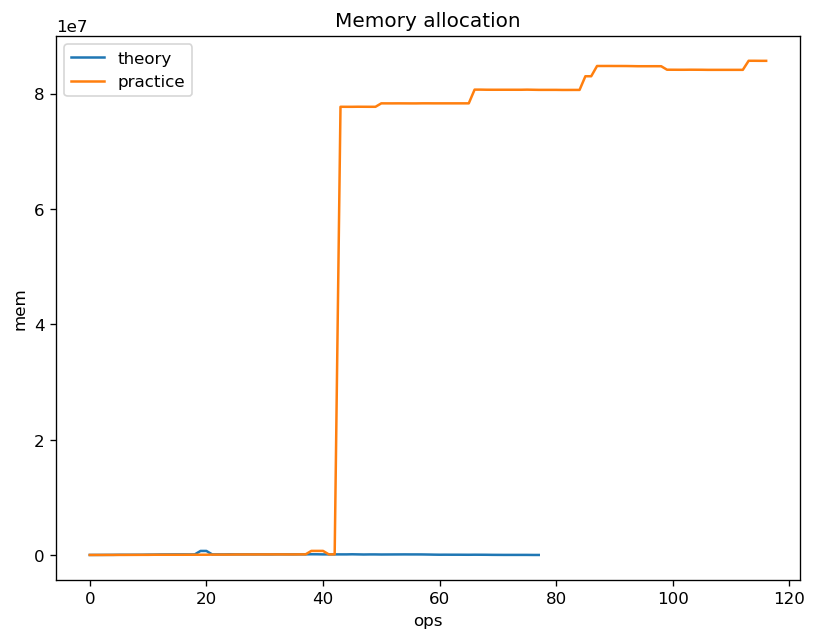

In [18]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
fig = figure(figsize=(8, 6), dpi=120)

plt.plot(mem_timeline, label='theory')
plt.plot(mem_timeline_real, label='practice')

plt.xlabel('ops')
plt.ylabel('mem')
plt.title('Memory allocation')
plt.legend()

# plt.show()
plt.savefig("mem_alloc.png")